# Seasonality in Salinity, Temperature, and Overturning of the North Atlantic

__Goal:__ to investigate monthly changes in surface salinity and temperature of the North Atlantic (40N to ~70N), specifically the major deep water formation regions: the Labrador Sea and the Greenland, Iceland and Norwegian Seas (GINS). Also, the influence the changes in surface salinity and temperature have on the overturning in the North Atlantic will be investigated.

__Data used:__ The data used in this project is the “Estimating the Circulation and Climate of the Ocean” (ECCO) project. ECCO is a multi-organizational effort that combines observations with models to generate three-dimensional global state of the ocean. Observational data include satellite observations (e.g. satellite altimetry, GRACE twin satellites, Aquarius raiometers) and in situ measurements (e.g. Argo floats), and modeling is based on the MIT general circulation model (MITgcm). ECCO Version 4 Release 3, the version used in this final project, covers the period 1992-2015, and is the first multi-decadal ECCO estimate that includes the Arctic Ocean.

__The planned analysis:__

1. Generate maps that show surface salinity changes averaged monthly.
2. Generate maps that show surface temperature changes averaged monthly.
3. Compute the volumetric transport or streamfuction across a section in the North Atlantic, and generate figures that show monthly changes in the overturning in the North Atlantic.
4. If time allows, analyze the correlation between overturning changes and sea surface temperature/salinity changes. 

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import path as mpath
%matplotlib inline
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
%config InlineBackend.figure_format = 'retina'
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

ECCO Version 4 Release 3 comes with a Python package that contains a library of routines that are helpful for analyzing the ECCO v4 data. Here, I am downloading the package:

In [2]:
import sys
sys.path.append('/home/jovyan/rces-final-project-jkim/ECCOv4-py')
import ecco_v4_py as ecco

ECCO v4 data is also available in the pangeo cloud as an intake catalogue. The instructions on how to load the data into a notebook are given:

In [3]:
import intake
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds = cat["ECCOv4r3"].to_dask()
ds = ds.rename({'face': 'tile'}) 
# the ECCO package loaded above uses the dimension name 'tile', so changing the name to avoid complications
ds

<xarray.Dataset>
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, tile: 13, time: 288, time_snp: 287)
Coordinates:
    Depth      (tile, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    PHrefC     (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    PHrefF     (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    XC         (tile, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC         (tile, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YG         (tile, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Z          (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Zl         (k_l) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Zp1        (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    Zu         (k_u) float32 dask.a

ECCO variables do not exist over a global dimension, but individual dimensions called "tiles" or "faces." Like this:

(-0.5, 652.5, 565.5, -0.5)

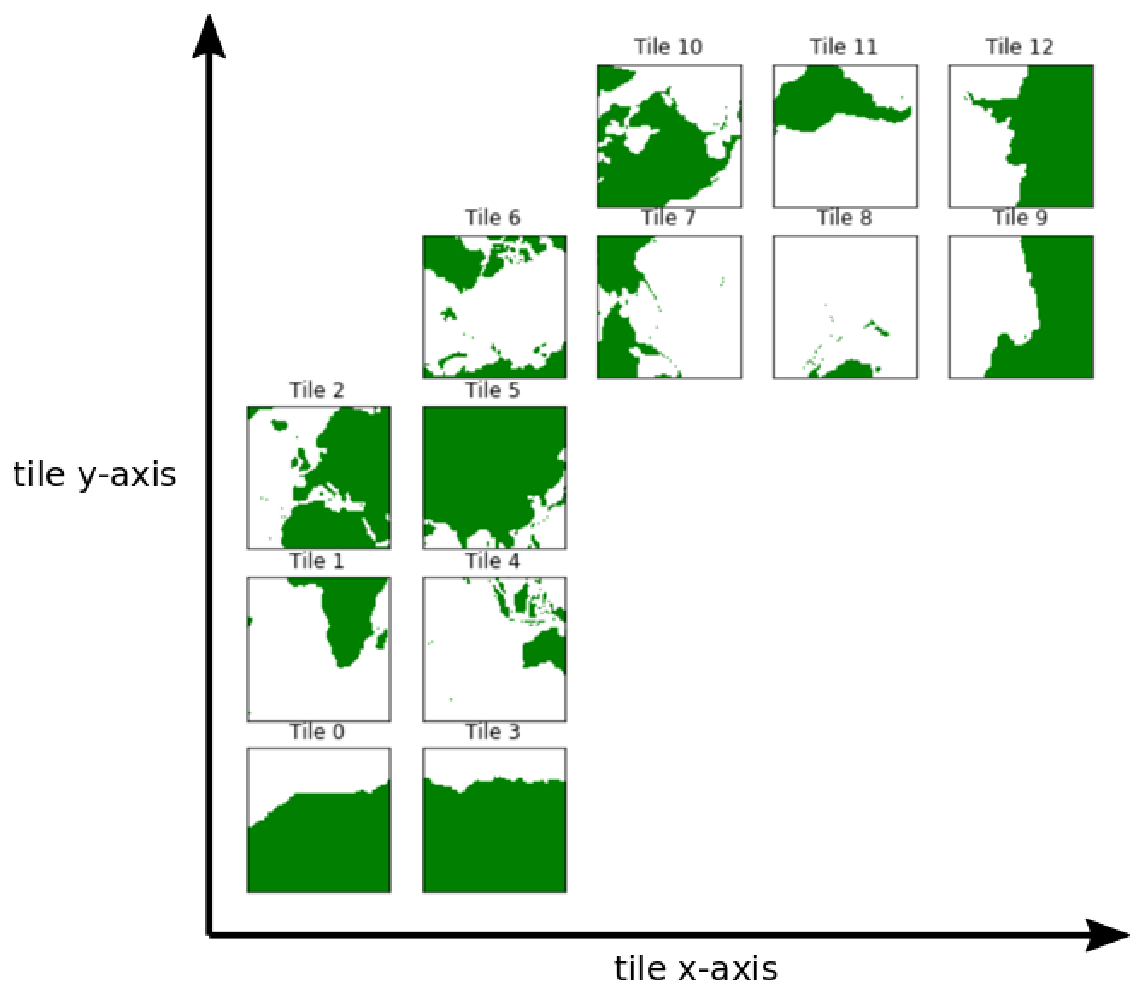

In [4]:
image = plt.imread('llc90_0.png')

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(image)
ax.axis('off')

In order to create a global map, the tiles/faces need to be put together in a grid. There are several ways to do this (e.g. built-in function provided in ECCO v4, creating a manually-written function that converts data projections into a gridded projection). Here, I am following a grid function example provided by MITgcm, called LLCMapper. 

The lat-lon-cap (LLC) is the decomposition of the spherical Earth into a Cartesian curvilinear coordinate system, which divides the Earth into 13 tiles. Each tile consists of 90x90 grid cells in the horizontal and 50 vertical levels.

In [5]:
# Pyresample is a python package for resampling geospatial image data. 
import pyresample

class LLCMapper:

    def __init__(self, ds, dx=0.25, dy=0.25): #latitude, longitude spacing for grid resampling
        # Extract LLC 2D coordinates
        lons_1d = ds.XC.values.ravel() #ravel transforms a multi-dimensional array into a 1-D or flat array
        lats_1d = ds.YC.values.ravel()

        # Define original grid
        # Pyresample is a python package for resampling geospatial image data
        # A swath is defined by the longitude and latitude coordinates for the pixels it represents 
        # The coordinates represent the center point of each pixel
        self.orig_grid = pyresample.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)

        # Longitudes & latitudes to which data will be interpolated
        lon_tmp = np.arange(-180, 180, dx) + dx/2
        lat_tmp = np.arange(-90, 90, dy) + dy/2

        # Define the lat lon points of the two parts
        self.new_grid_lon, self.new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
        self.new_grid  = pyresample.geometry.GridDefinition(lons=self.new_grid_lon,
                                                            lats=self.new_grid_lat)

    def __call__(self, da, ax=None, projection=ccrs.Robinson(), lon_0=-60, **plt_kwargs):

        assert set(da.dims) == set(['tile', 'j', 'i']), "da must have dimensions ['tile', 'j', 'i']"
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 6))
            ax = plt.axes(projection=projection)

        field = pyresample.kd_tree.resample_nearest(self.orig_grid, da.values,
                                                    self.new_grid,
                                                    radius_of_influence=100000,
                                                    fill_value=None)


        vmax = plt_kwargs.pop('vmax', field.max())
        vmin = plt_kwargs.pop('vmin', field.min())

        x,y = self.new_grid_lon, self.new_grid_lat

        # Find index where data is splitted for mapping
        split_lon_idx = round(x.shape[1]/(360/(lon_0 if lon_0>0 else lon_0+360)))


        p = ax.pcolormesh(x[:,:split_lon_idx], y[:,:split_lon_idx], field[:,:split_lon_idx],  
                         vmax=vmax, vmin=vmin, transform=ccrs.PlateCarree(), zorder=1, **plt_kwargs)
        p = ax.pcolormesh(x[:,split_lon_idx:], y[:,split_lon_idx:], field[:,split_lon_idx:], 
                         vmax=vmax, vmin=vmin, transform=ccrs.PlateCarree(), zorder=2, **plt_kwargs)

        ax.add_feature(cartopy.feature.LAND, zorder=3)
        ax.coastlines('110m', linewidth=0.8, zorder=4)
        ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', zorder=10)
        
        label = ''
        if da.name is not None:
            label = da.name
        if 'units' in da.attrs:
            label += ' [%s]' % da.attrs['units']
        cb = plt.colorbar(p, shrink=0.6, label=label, extend = 'both')
        return ax

In [6]:
mapper = LLCMapper(ds)
plt.rcParams.update({'font.size': 12})

Now, the LLCMapper function can be called on and multi-dimensional data can be plotted to cartopy maps.

## Surface salinity changes in the North Atlantic

To constrain the amount of data to work with, I am focusing on two regions in the North Atlantic: the Labrador Sea and the GIN Seas (the Greenland-Iceland-Scotland Ridge), major deep water formation regions. Here, I am creating masks for the regions and applying them to the data. 

In [7]:
# Labrador Sea
sal = ds.SALT
lat_bounds_lab = np.logical_and(sal.YC  > 56, sal.YC < 61)
lon_bounds_lab = np.logical_and(sal.XC  > -58, sal.XC < -52)
lat_lon_bounds_lab = np.logical_and(lon_bounds_lab, lat_bounds_lab)
sal_lab = sal.where(lat_lon_bounds_lab, np.nan).isel(k=0)

# GIN Sea (between Greenland, Iceland and Norway)
lat_bounds_GIN = np.logical_and(sal.YC  > 58, sal.YC < 62)
lon_bounds_GIN = np.logical_and(sal.XC  > -35, sal.XC < -20)
lat_lon_bounds_GIN = np.logical_and(lon_bounds_GIN, lat_bounds_GIN)
sal_GIN = sal.where(lat_lon_bounds_GIN, np.nan).isel(k=0)

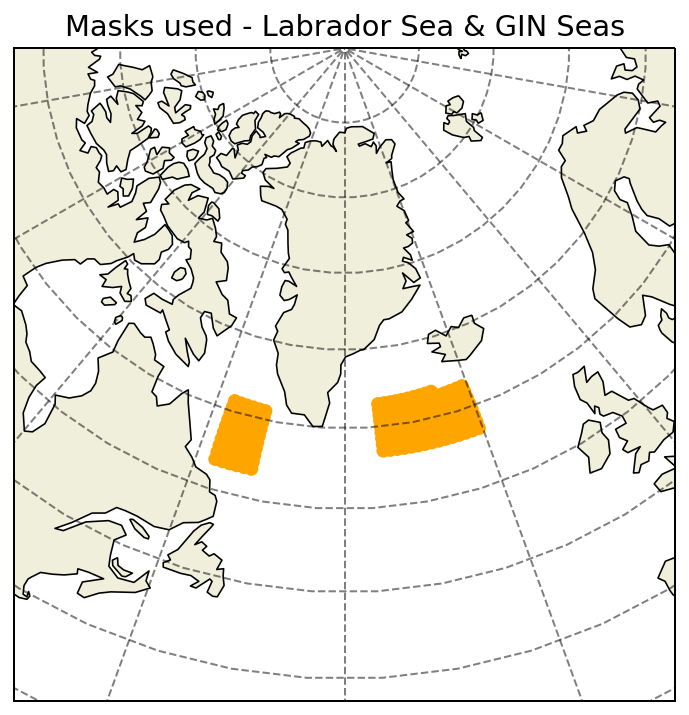

In [8]:
# not using the mapper here, as I am simply showing the regions that I constrained the data to, which seems 
# to become overcomplicated when the mapper is used

plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-40))
ax.set_extent([-70, -10, 40, 90], ccrs.PlateCarree())
ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--')
ax.coastlines('110m', linewidth=0.8)
ax.add_feature(cartopy.feature.LAND)
ax.set_title('Masks used - Labrador Sea & GIN Seas')

plt.scatter(ds.XC.sel(tile=10), ds.YC.sel(tile=10), sal_lab.isel(time=0, tile=10), c='orange',  
           transform=ccrs.PlateCarree())
plt.scatter(ds.XC.sel(tile=2), ds.YC.sel(tile=2), sal_GIN.isel(time=0, tile=2), c='orange',
           transform=ccrs.PlateCarree())

Using the masked data, time-wise changes in the surface salinities of the regions are observed. 

(727198.0, 735964.0)

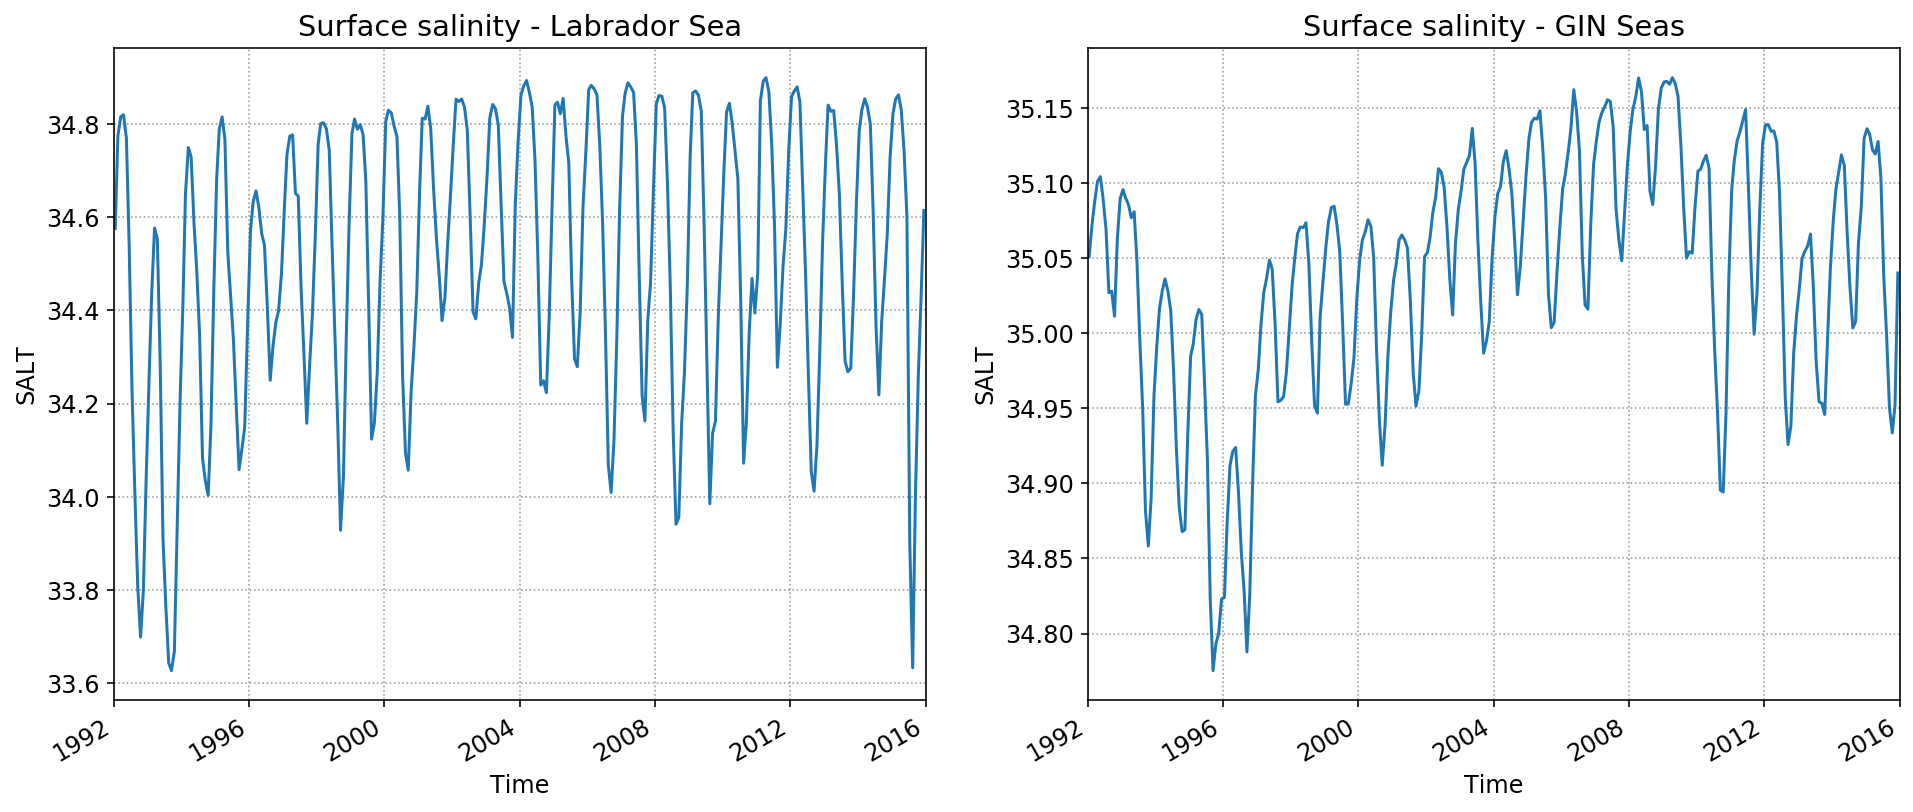

In [9]:
fig, axes = plt.subplots(figsize=(16,6), ncols=2)
sal_lab.mean(dim=('tile','i','j')).plot(ax = axes[0])
axes[0].set_title('Surface salinity - Labrador Sea')
axes[0].grid(which = 'major', linestyle = 'dotted', color = '0.6')
axes[0].set_xlim('1992','2016')

sal_GIN.mean(dim=('tile','i','j')).plot(ax = axes[1])
axes[1].set_title('Surface salinity - GIN Seas')
axes[1].grid(which = 'major', linestyle = 'dotted', color = '0.6')
axes[1].set_xlim('1992','2016')

The salinity changes seen in above figures seem to show annual variabilities, each year with minimum and maximum salinities occurring in certain months. 
In order to take a closer look, monthly averages are calculated over the entire data span (1992-2016). 

In [10]:
# monthly climatology (temperature)
SALT_month = ds.SALT.sel(k = 0).groupby('time.month').mean(dim='time')
SALT_month.attrs['units'] = 'psu'

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/common.py:657: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


Text(0, 0.5, 'Salinity (psu)')

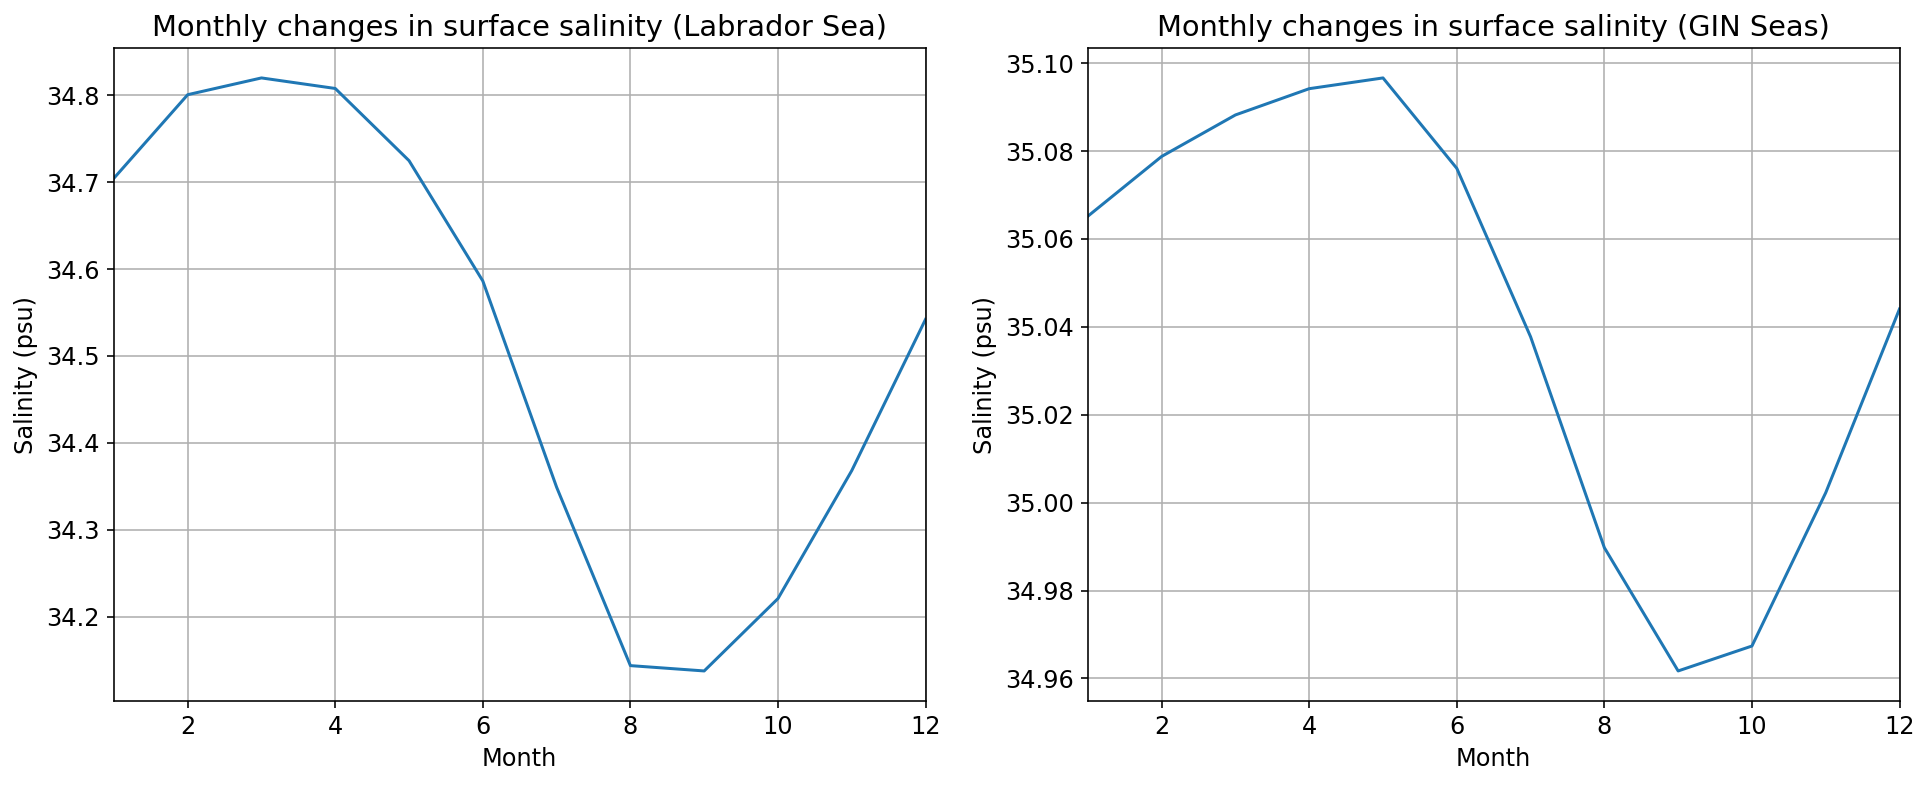

In [11]:
sal_lab_month = SALT_month.where(lat_lon_bounds_lab, np.nan)
sal_GIN_month = SALT_month.where(lat_lon_bounds_GIN, np.nan)

fig, axes = plt.subplots(figsize=(16,6), ncols=2)
sal_lab_month.mean(dim=('tile','i','j')).plot(ax=axes[0])
axes[0].set_title('Monthly changes in surface salinity (Labrador Sea)')
axes[0].grid()
axes[0].set_xlim(1,12)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Salinity (psu)')

sal_GIN_month.mean(dim=('tile','i','j')).plot(ax=axes[1])
axes[1].set_title('Monthly changes in surface salinity (GIN Seas)')
axes[1].grid()
axes[1].set_xlim(1,12)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Salinity (psu)')

The monthly averaged sea surface salinities of the two regions show that the highest salinities occur during March-May. This may be due to the increased formation of sea ice in the northern North Atlantic regions in winter that result in increased brine release into the ocean during freezing of sea ice, as well as a reduction of freshwater runoff from the nearby land areas. 

The lowest salinities occur around August-September. This may be a result of sea ice and continental ice melting and increased river runoff during summer.

To visualize the salinity changes, the entire North Atlantic is mapped below for the months when the highest and lowest sea surface salinities are observed in the Labrador and GIN Seas. 

Text(0.5, 1.0, 'September')

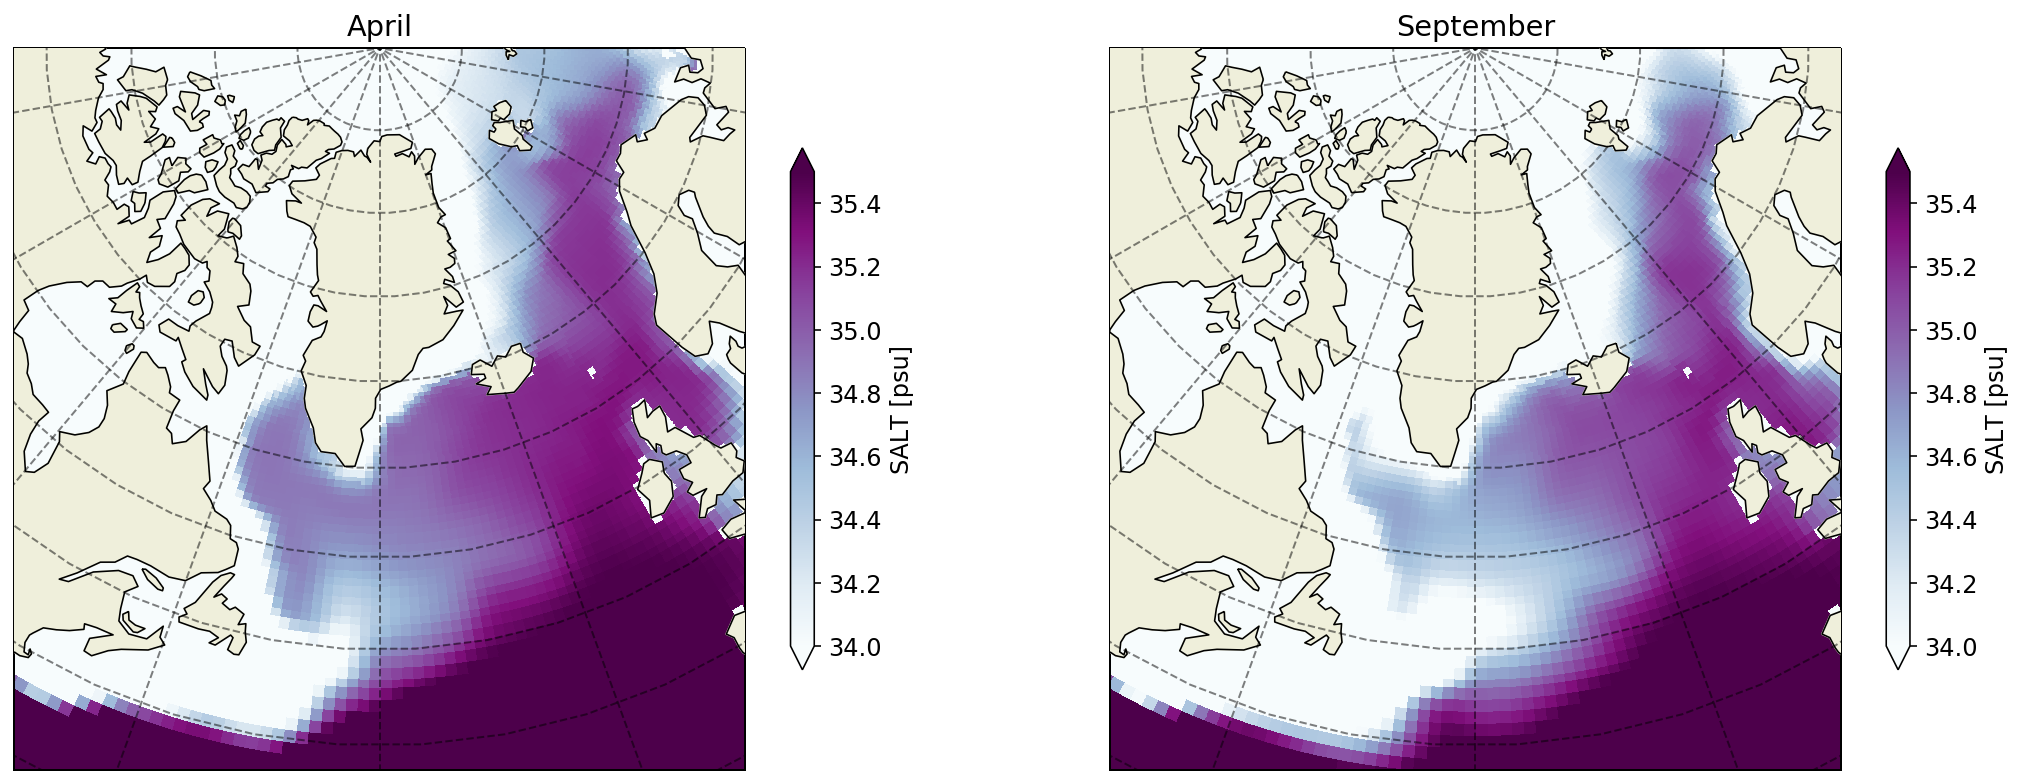

In [12]:
plt.figure(figsize=(18,8))
ax1 = plt.subplot(121, projection = ccrs.NorthPolarStereo(central_longitude=-40))
ax1 = mapper(SALT_month.sel(month = 4), ax = ax1, vmax = 35.5, vmin = 34, cmap = 'BuPu', 
               projection=ccrs.NorthPolarStereo(central_longitude=-40))
ax1.set_extent([-70, -10, 40, 90], ccrs.PlateCarree())
ax1.set_title('April')


ax2 = plt.subplot(122, projection=ccrs.NorthPolarStereo(central_longitude=-40))
ax2 = mapper(SALT_month.sel(month = 9),  ax = ax2, vmax = 35.5, vmin = 34, cmap = 'BuPu',
               projection=ccrs.NorthPolarStereo(central_longitude=-40))
ax2.set_extent([-70, -10, 40, 90], ccrs.PlateCarree())
ax2.set_title('September')

## Surface temperature changes in the North Atlantic

Using the previously mentioned masked focusing on the Labrador and GIN Seas, sea surface temperature changes are analyzed here.

In [13]:
temp = ds.THETA
temp_lab = temp.where(lat_lon_bounds_lab, np.nan).isel(k=0)
temp_GIN = temp.where(lat_lon_bounds_GIN, np.nan).isel(k=0)

(727198.0, 735964.0)

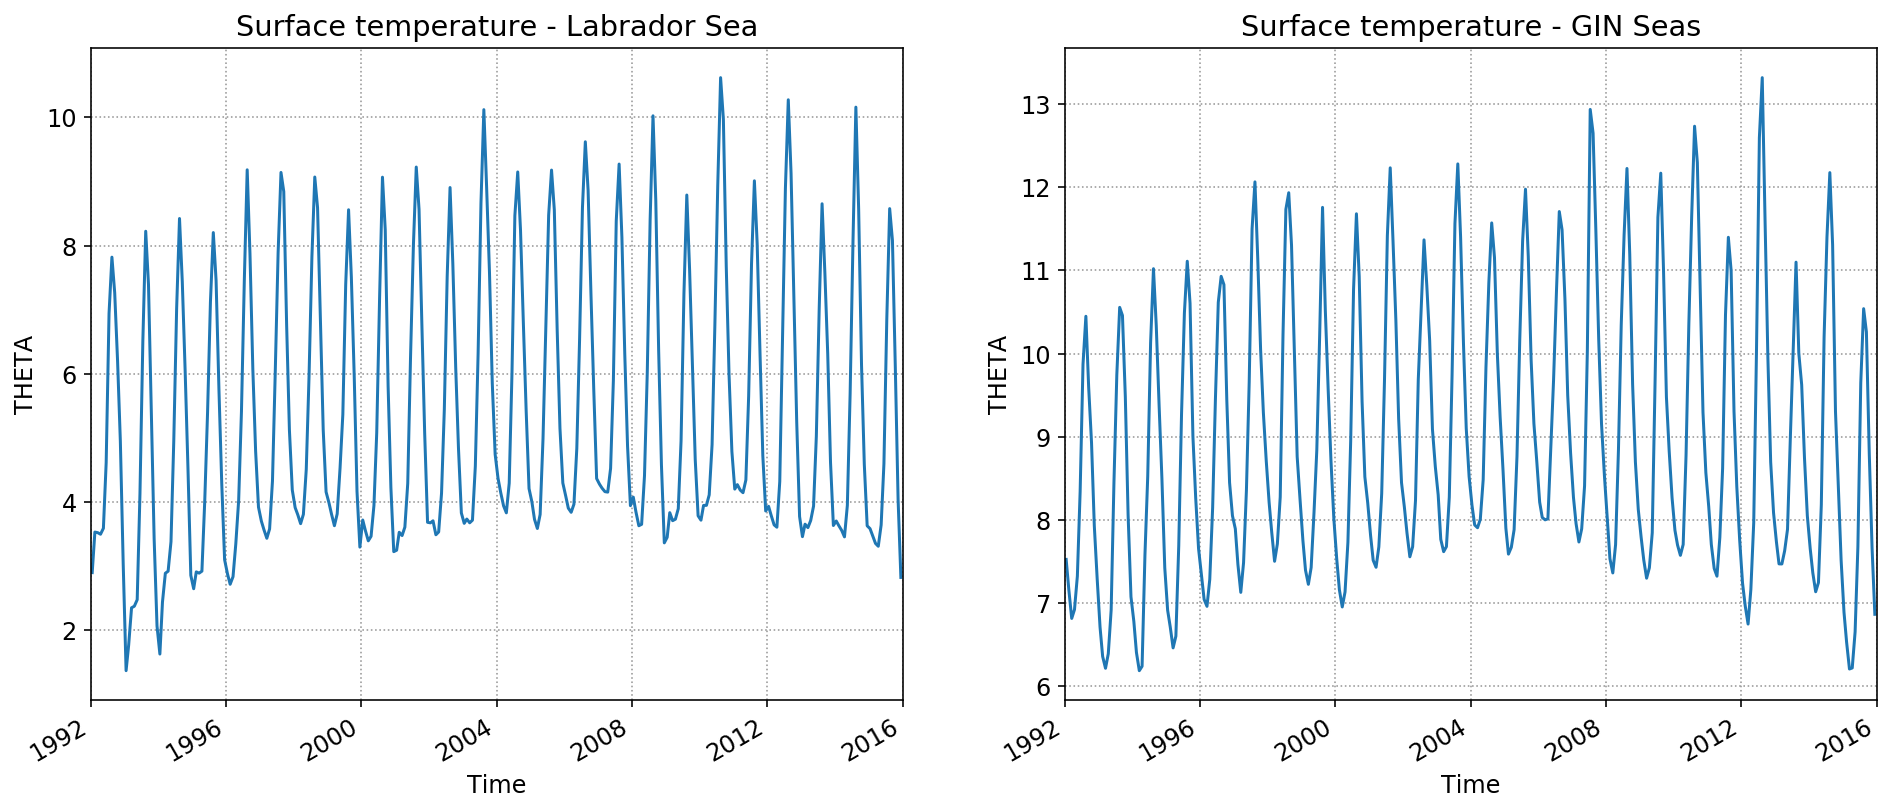

In [14]:
fig, axes = plt.subplots(figsize=(16,6), ncols=2)
temp_lab.mean(dim=('tile','i','j')).plot(ax = axes[0])
axes[0].set_title('Surface temperature - Labrador Sea')
axes[0].grid(which = 'major', linestyle = 'dotted', color = '0.6')
axes[0].set_xlim('1992','2016')

temp_GIN.mean(dim=('tile','i','j')).plot(ax = axes[1])
axes[1].set_title('Surface temperature - GIN Seas')
axes[1].grid(which = 'major', linestyle = 'dotted', color = '0.6')
axes[1].set_xlim('1992','2016')

Similar to salinity, sea surface temperatures of the two regions show annual variabilities. The temperature changes, however, seem to be more consistent over time than the previously seen salinity changes in the regions over the same time period. For example, surface salinities in GIN Seas fluctuated drastically 1992-1998, but such drastic changes are not observed in temperature changes. 

In [15]:
# monthly averages of temperature
THETA_month = ds.THETA.sel(k = 0).groupby('time.month').mean(dim='time')
THETA_month.attrs['units'] = 'degree C'

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/common.py:657: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


Text(0, 0.5, 'Temperature (degree C)')

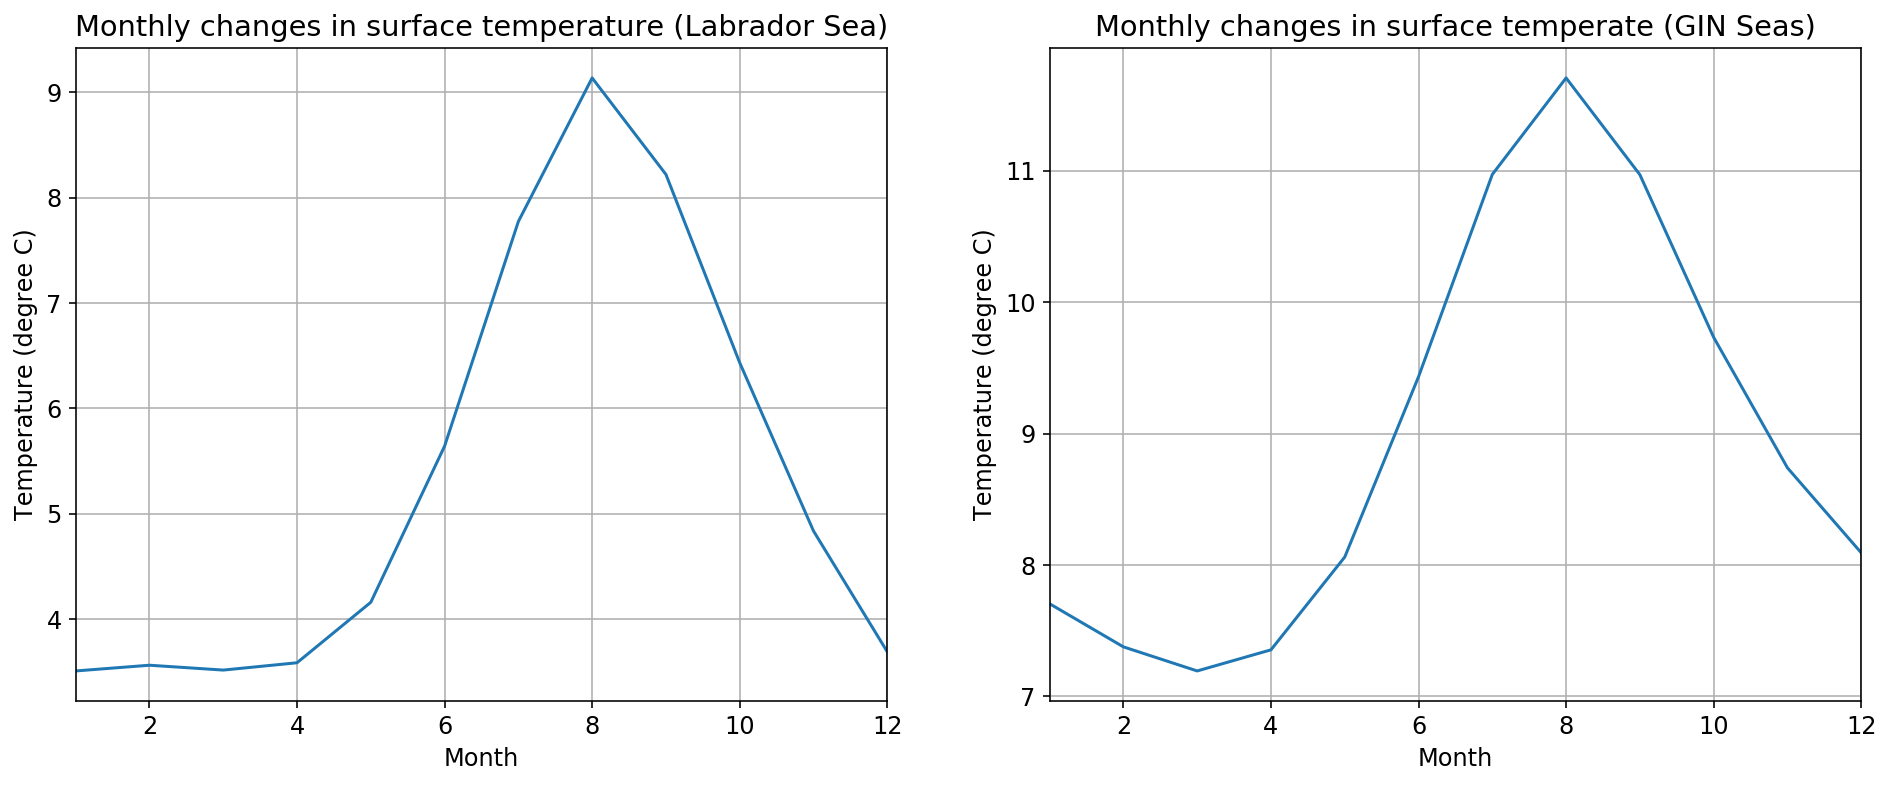

In [16]:
temp_lab_month = THETA_month.where(lat_lon_bounds_lab, np.nan)
temp_GIN_month = THETA_month.where(lat_lon_bounds_GIN, np.nan)

fig, axes = plt.subplots(figsize=(16,6), ncols=2)
temp_lab_month.mean(dim=('tile','i','j')).plot(ax=axes[0])
axes[0].set_title('Monthly changes in surface temperature (Labrador Sea)')
axes[0].grid()
axes[0].set_xlim(1,12)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Temperature (degree C)')

temp_GIN_month.mean(dim=('tile','i','j')).plot(ax=axes[1])
axes[1].set_title('Monthly changes in surface temperate (GIN Seas)')
axes[1].grid()
axes[1].set_xlim(1,12)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Temperature (degree C)')

The monthly temperature changes are very similar in both regions. The highest temperature occurs in August and the lowest temperature occurs in March in both regions. As these changes occur during the Northern Hemisphere summer and winter, when the air temperature is expected to be high and low, the changes in sea surface temperature seem to indicate that they are mainly controlled by atmospheric conditions, and the heat exchange between ocean and atmosphere. 

Text(0.5, 1.0, 'August')

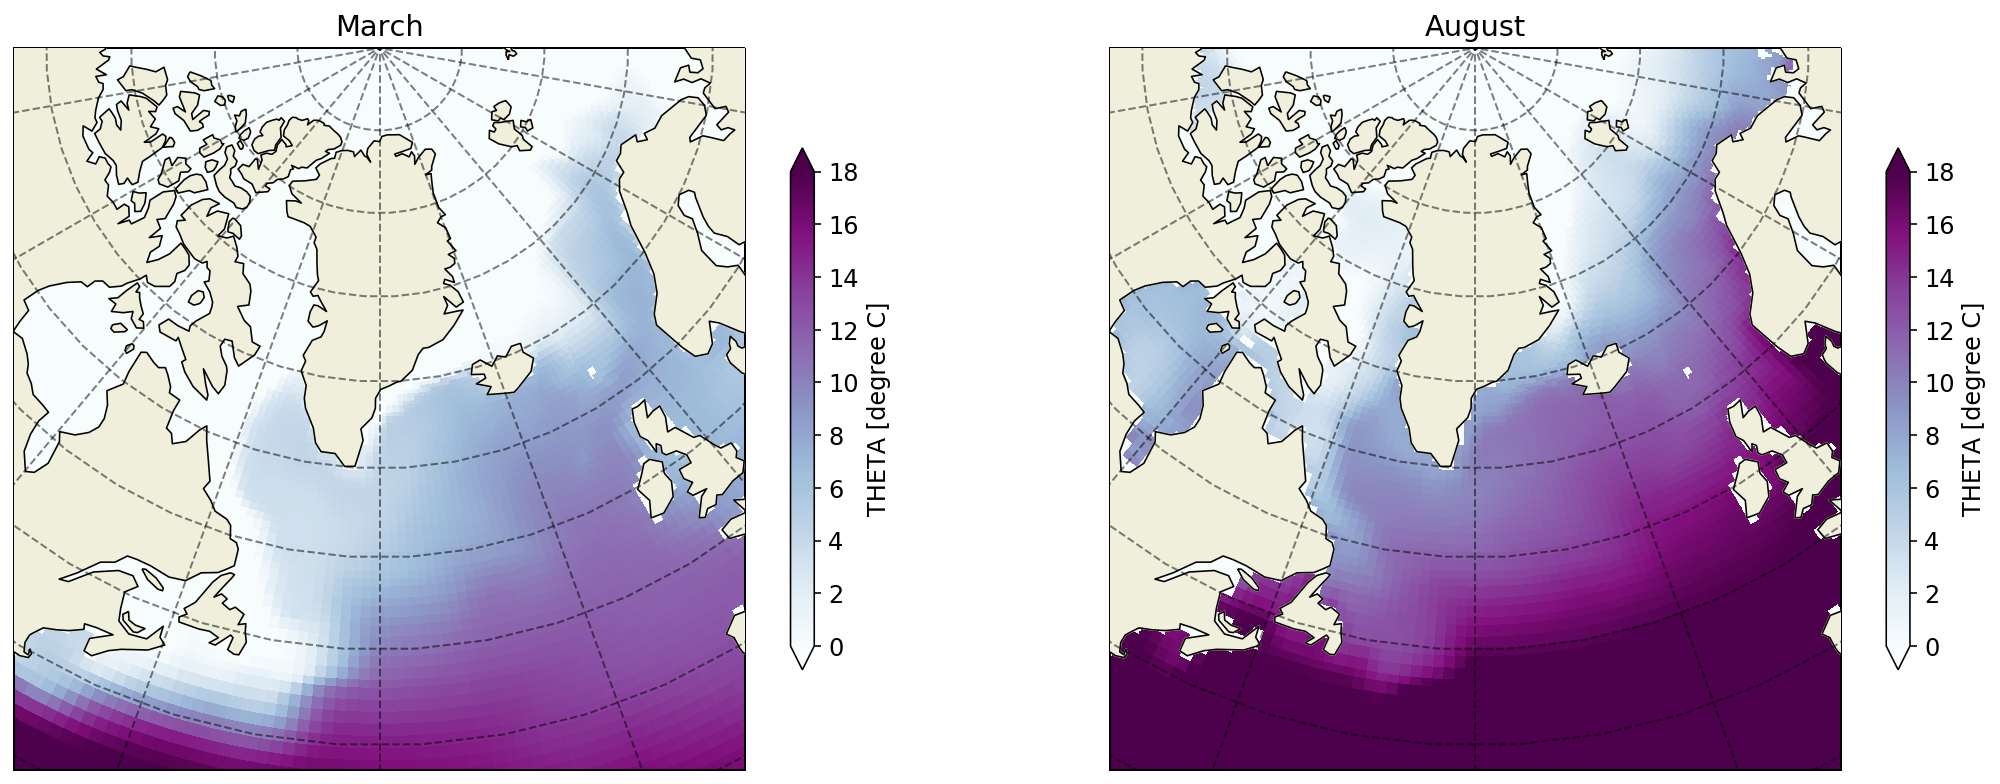

In [17]:
plt.figure(figsize=(18,8))
ax1 = plt.subplot(121, projection = ccrs.NorthPolarStereo(central_longitude=-40))
ax1 = mapper(THETA_month.sel(month = 3), ax = ax1, vmax = 18, vmin = 0, cmap = 'BuPu', 
               projection=ccrs.NorthPolarStereo(central_longitude=-40))
ax1.set_extent([-70, -10, 40, 90], ccrs.PlateCarree())
ax1.set_title('March')

ax2 = plt.subplot(122, projection=ccrs.NorthPolarStereo(central_longitude=-40))
ax2 = mapper(THETA_month.sel(month = 8), ax = ax2, vmax = 18, vmin = 0, cmap = 'BuPu', 
               projection=ccrs.NorthPolarStereo(central_longitude=-40))
ax2.set_extent([-70, -10, 40, 90], ccrs.PlateCarree())
ax2.set_title('August')

## Volume transport in the North Atlantic

Here, volumetric rate of transport of ocean currents in the deep water formation regions will be analyzed. To calculate the volume transports across the regions, sections need to be defined. The sections will be used as the planes through which currents pass orthogonally. 
In order to define the sections, I am using one of the built-in packages that come with ECCO v4 called "get_section_line_masks." 

In [18]:
# defining the sections through which volumetric transports of water will be calculated
pt1_east = [-44, 60]
pt2_east = [-10, 52]

pt1_west = [-56, 51]
pt2_west = [-45, 60]

In [19]:
# creating masks
maskC_east, maskW_east, maskS_east = ecco.get_section_line_masks(pt1_east,pt2_east,ds)
maskC_west, maskW_west, maskS_west = ecco.get_section_line_masks(pt1_west,pt2_west,ds)
maskC_tot = (maskC_east+maskC_west).where(maskC_east+maskC_west==1,0)
maskW_tot = (maskW_east+maskW_west).where(np.abs(maskW_east)+np.abs(maskW_west)==1,0)
maskS_tot = (maskS_east+maskS_west).where(np.abs(maskS_east)+np.abs(maskS_west)==1,0)

The sections used for volumetric transports are shown in the map given below. 

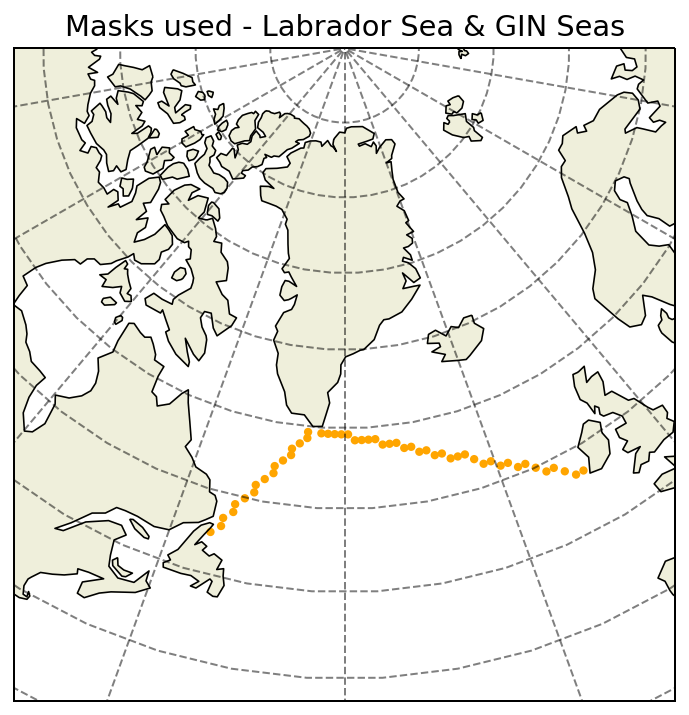

In [20]:
plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-40))
ax.set_extent([-70, -10, 40, 90], ccrs.PlateCarree())
ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--')
ax.coastlines('110m', linewidth=0.8)
ax.add_feature(cartopy.feature.LAND)
ax.set_title('Masks used - Labrador Sea & GIN Seas')

plt.scatter(ds.XC.sel(tile=[2,10]), ds.YC.sel(tile=[2,10]), maskC_tot.sel(tile=[2,10])*10, c='orange', 
           transform=ccrs.PlateCarree())

Using the section masks, and another ECCO built-in package called "calc_section_stf", the overturning streamfunctions across the planes normal to the defined sections are computed.

In [21]:
# it takes some time to run this code... (3 mins?)
stf_east = ecco.calc_section_stf(ds,
                                 pt1=pt1_east, 
                                 pt2=pt2_east,
                                 section_name='East Overturning Streamfunction').compute()

stf_west = ecco.calc_section_stf(ds, 
                                 pt1=pt1_west, 
                                 pt2=pt2_west,
                                 section_name='West Overturning Streamfunction').compute()

stf_tot = ecco.calc_section_stf(ds,
                                maskW=maskW_tot, 
                                maskS=maskS_tot,
                                section_name='Total Overturning Streamfunction').compute()

/home/jovyan/rces-final-project-jkim/ECCOv4-py/ecco_v4_py/get_section_masks.py:51: UserWarning: 
Section name eastoverturningstreamfunction unavailable as pre-defined section
  warnings.warn('\nSection name %s unavailable as pre-defined section' % section_name)
/home/jovyan/rces-final-project-jkim/ECCOv4-py/ecco_v4_py/get_section_masks.py:51: UserWarning: 
Section name westoverturningstreamfunction unavailable as pre-defined section
  warnings.warn('\nSection name %s unavailable as pre-defined section' % section_name)
/home/jovyan/rces-final-project-jkim/ECCOv4-py/ecco_v4_py/get_section_masks.py:51: UserWarning: 
Section name totaloverturningstreamfunction unavailable as pre-defined section
  warnings.warn('\nSection name %s unavailable as pre-defined section' % section_name)


In [22]:
# monthly volumetric transports
stf_east_m = stf_east.groupby('time.month').mean(dim='time')
stf_west_m = stf_west.groupby('time.month').mean(dim='time')
stf_tot_m = stf_tot.groupby('time.month').mean(dim='time')

In [23]:
def depth_stf_vs_time(stf_ds,label):
    fig = plt.figure(figsize=(18,6))

    # Time evolving
    plt.subplot(1,4,(1,3))
    plt.pcolormesh(stf_ds['month'],stf_ds['Z'],stf_ds['psi_moc'].T, cmap = 'inferno')
    plt.title('ECCOv4r3\nOverturning streamfunction across the %s section [Sv]' % label)
    plt.ylabel('Depth [m]')
    plt.xlabel('Time [month]')
    plt.grid(which = 'major', linewidth = 2, linestyle = 'dotted', color = '0.7')
    cb = plt.colorbar()
    cb.set_label('[Sv]')

    plt.subplot(1,4,4)
    plt.plot(stf_ds['psi_moc'].mean('month'),stf_ds['Z'])
    plt.title('ECCOv4r3\nTime mean streamfunction, the %s' % label)
    plt.ylabel('Depth [m]')
    plt.xlabel('[Sv]')
    plt.grid()
    plt.show()
    

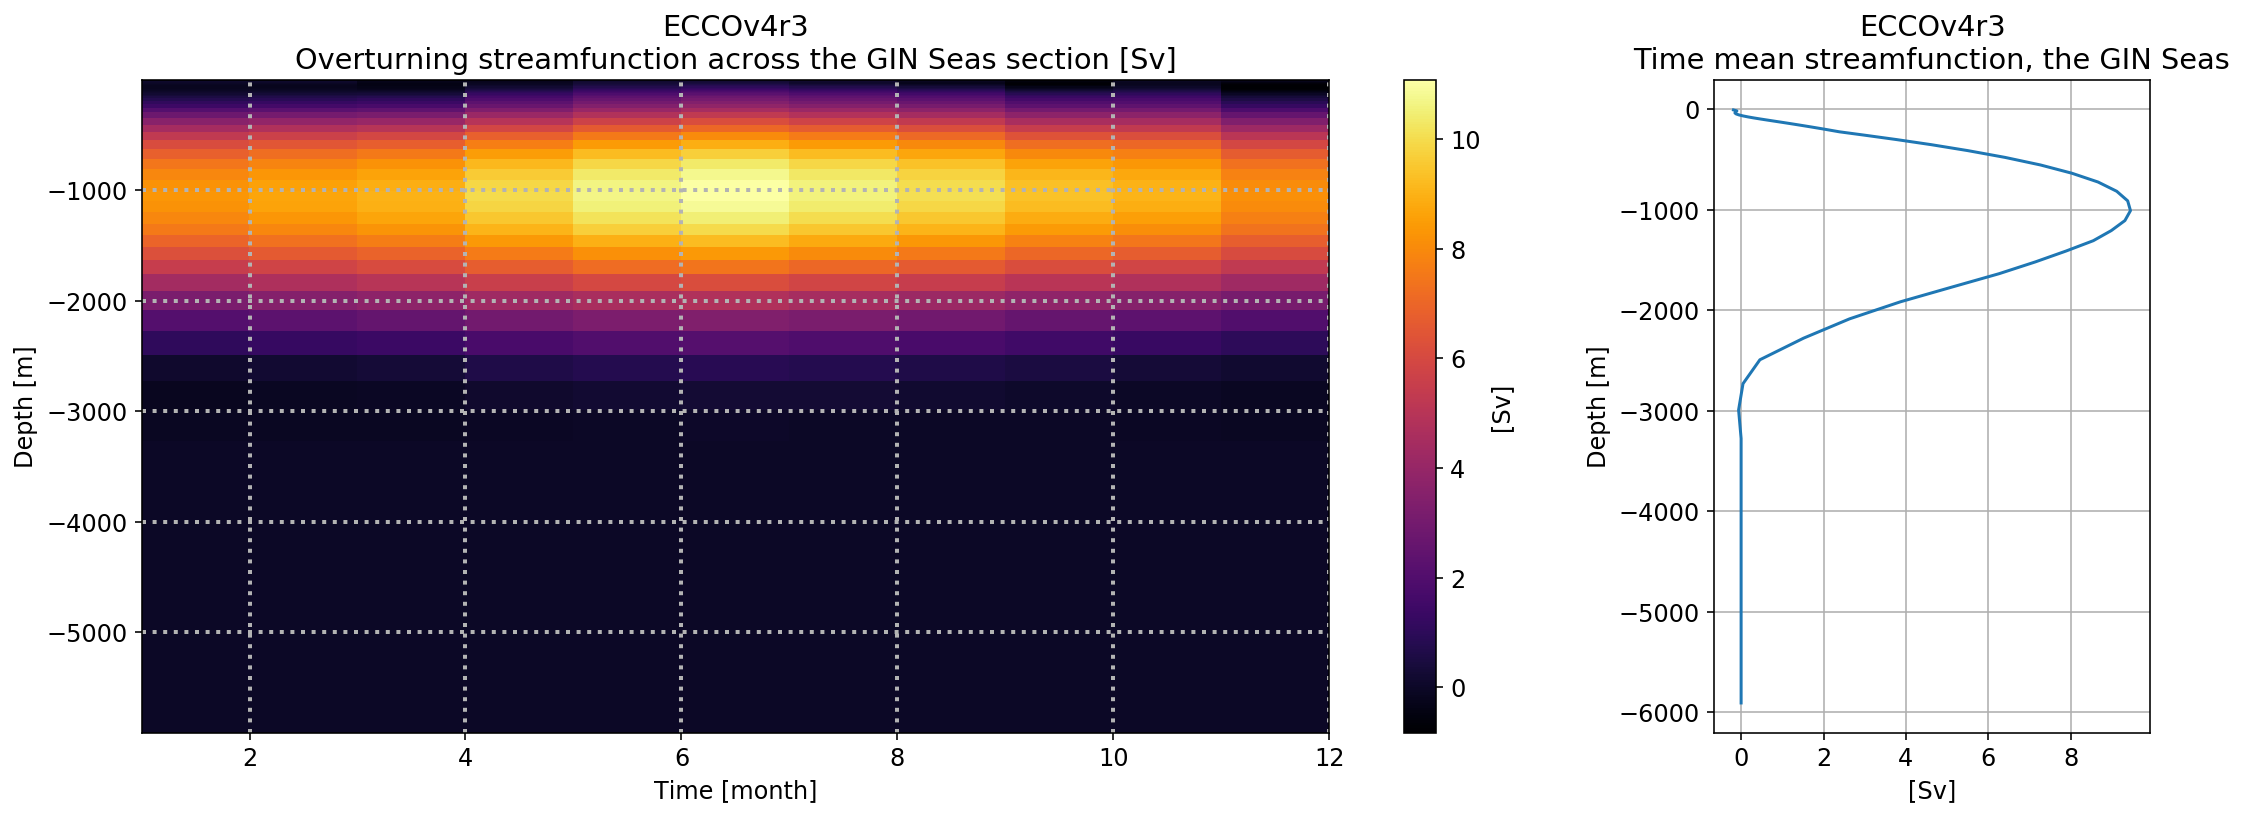

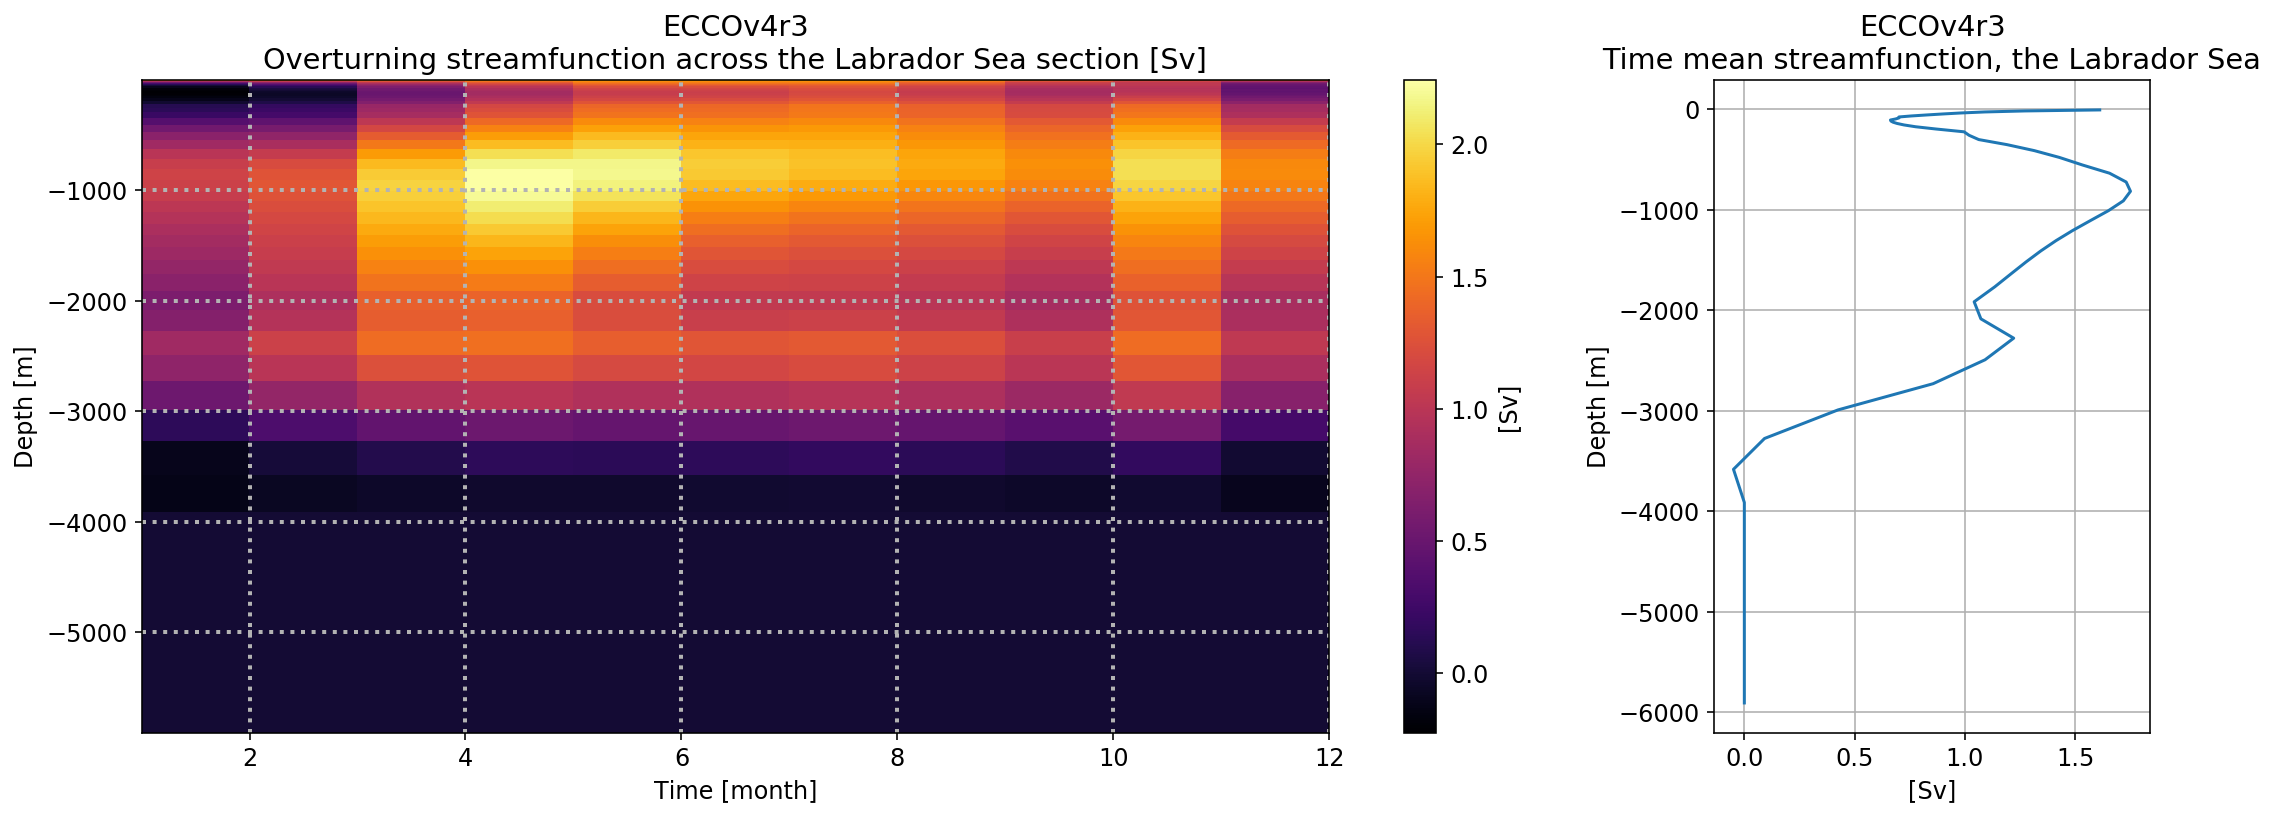

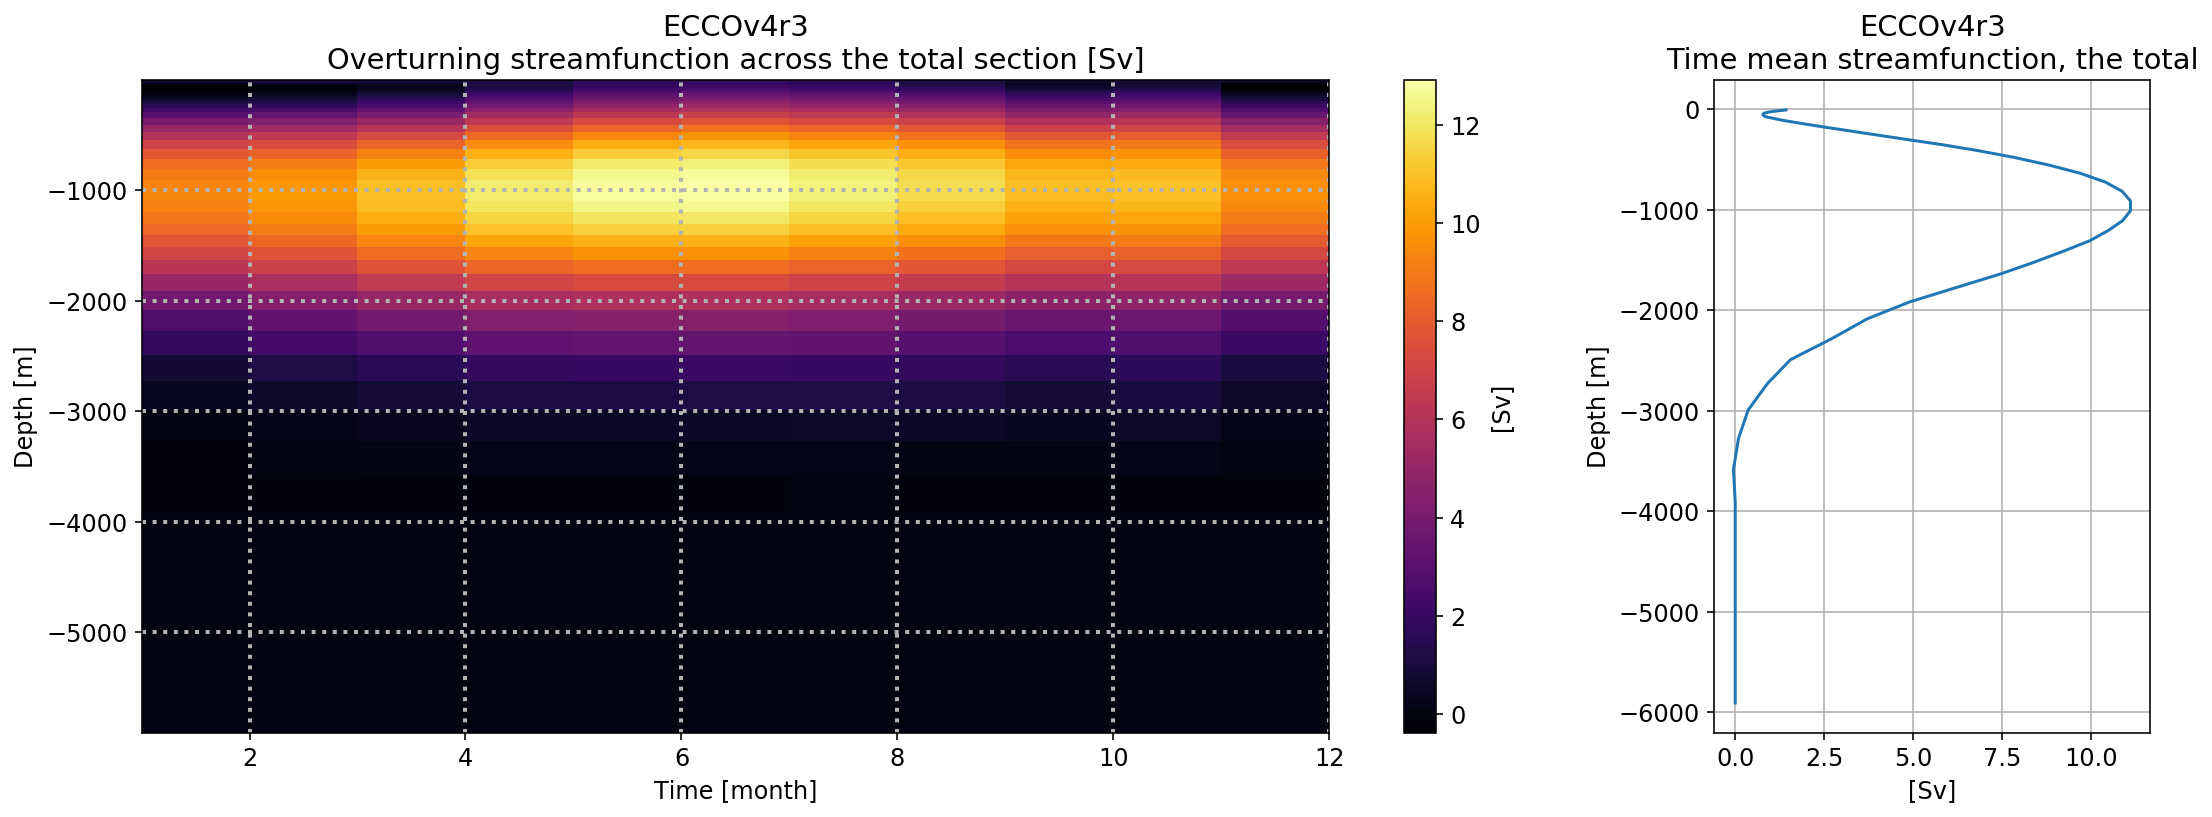

In [29]:
depth_stf_vs_time(stf_east_m,'GIN Seas')
depth_stf_vs_time(stf_west_m,'Labrador Sea')
depth_stf_vs_time(stf_tot_m,'total')

The results show that the volume transport across the West section in the Labrador Sea is highest in April-June. These months coincide with the months when surface salinity is decreasing right after the months of highest salinities, and surface temperature is increasing from the months of lowest temperatures. This may be indicative of a lag between the time when highly dense surface waters are formed and the time when such dense water masses move out of the Labrador Sea basin as intermediate-deep water masses. Another possibility is that the monthly averages of salinity and temperature are not quite representative of what really influences the overturning currents, that they represent too short of a period of time. Looking at interannual variabilities in salinity and temperature might be more useful when studying a long-term effect of surface salinity and temperature on overturning circulation. 

The volume transport across the East section in the GIN Seas is highest in May-July, and lowest in December-February. Similar to the Labrador Sea data, the months that would observe highly dense surface waters in the GIN Seas (winter months with high surface salinity and low temperature) do not match with the months with the largest volume transport out of the basin. Again, there may be a lag between dense surface water formation and deep water transport out of the basin, or the monthly averaging method is not adequate to conduct a correlation study between surface salinity/temperature and overturning circulation. 

It is also worth noting that the volume transport in the GIN Seas is higher (~ 8 Sv, time mean) than that in the Labrador Sea (~ 2 Sv, time mean). The total together comes up to >10 Sv. 

## Conclusion

Looking at the figures of the monthly averaged salinity and temperature data, and the volume transport data in the Labrador Sea abd GIN Seas, the correlations between them are not visually obvious. The next step would be to do a quantitative correlation analysis, perhaps through  regression analyses and by calculating the correlation coefficients of surface salinity vs volume transport, and surface temperature vs volume transport. Due to time constraint, such analysis is not done here. Another approach to take in the future is to look at the interannual variabilities in surface salinity and temperature of the Labrador and GIN Seas, and compare the results to time-variant changes in the overturning currents of the regions. 